# Notebook Objective<a id='Notebook Objective'></a>

In this notebook we'll be turing the final random forest regressor model for our world happiness data set. 

In preprocessing and training we determined that using all the features of our dataset was the best approach. 
Preprocessing and training were done using an our of the box RF regressor model with all parameters set at the defaults. 

In this notebook we'll see if we can beat the default scores through parameter tuning.

The tuning process will be automated. We'll be using the skopt module and gp.minimize()
to search out parameter space and minimize the MAE score for our model on the test set. 

The best parameters will then be used to create the final model, which will be trained on all the data we have and 
then saved for future use. 

We'll also be examining the feature importances in the final model to see if there are any additional 
insights there that might help us understand which features in our data have the greatest influence over our life ladder target variable. 

In [1]:
#Import Modules

import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

import joblib


In [2]:
#import cleaned_data for modeling
df_global = pd.read_csv('../data/interim/cleaned_data.csv', index_col = 0)

In [3]:
df_global.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
0,Afghanistan,South Asia,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,South Asia,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,South Asia,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,South Asia,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,South Asia,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


In [4]:
#Convert object type columns to numeric using encoding

country_label_encoder = LabelEncoder()
df_global['Country Name'] = country_label_encoder.fit_transform(df_global['Country Name'])

region_label_encoder = LabelEncoder()
df_global['Regional Indicator'] = region_label_encoder.fit_transform(df_global['Regional Indicator'])

In [5]:
df_global.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
0,0,6,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,0,6,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,0,6,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,0,6,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,0,6,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


# Train-Test Split<a id='Train-Test Split'></a>

In [6]:
#Define X and y prior to splitting
target_col = ['Life Ladder']
X = df_global.drop(target_col, axis = 1)
y = df_global[target_col]

In [7]:
#Train Test split global data - using test_size = 0.2 and random_state = 42 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

# Model Baseline<a id='Model Baseline'></a>

Here we use an 'out of the box' RF regressor model with no tuning to set a baseline for performance. 
The performance of our final model after hyperparamter tuning will be compared to this model where no tuning was done. 

In [8]:
rf_reg = RandomForestRegressor(random_state=42)
baseline_model = rf_reg.fit(X_train,y_train.values.ravel())

baseline_model_y_pred_test = baseline_model.predict(X_test)

#baseline r2
baseline_r2_score_test = r2_score(y_test,baseline_model_y_pred_test)
print(f"The r2 score for the baseline model on the test data is: {baseline_r2_score_test}")

#baseline MAE
baseline_mae_score_test = mean_absolute_error(y_test,baseline_model_y_pred_test)
print(f"The MAE score for the baseline model on the test data is: {baseline_mae_score_test}")

#baseline MAPE
baseline_mape_score_test = mean_absolute_percentage_error(y_test,baseline_model_y_pred_test)
print(f"The MAPE score for the baseline model on the test data is: {baseline_mape_score_test}")





The r2 score for the baseline model on the test data is: 0.8960661044910936
The MAE score for the baseline model on the test data is: 0.28505371117097045
The MAPE score for the baseline model on the test data is: 0.05635984115967334


# Search Hyperparamter Space<a id='Search Hyperparamter Space'></a>

In [9]:
# Define the objective function
def objective(params):
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = params
    
    # Create Random Forest regressor with specified hyperparameters
    rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                          max_depth=(max_depth),
                                          min_samples_split= int(min_samples_split),
                                          min_samples_leaf=int(min_samples_leaf),
                                          max_features = (max_features),
                                          oob_score=True,
                                          random_state=42)
    
    rf_model.fit(X_train, y_train.values.ravel())

    y_pred_test_set = rf_model.predict(X_test)
    
    # Evaluate the model using the test set
    model_MAE_test = mean_absolute_error(y_test,y_pred_test_set)
    
    
    # Return the mean squared error
    return model_MAE_test

# Define the search space

max_depth_values = [4,8,10]
max_depth_values.append(None)


space = [Integer(9000,11000, name='n_estimators'),
         Categorical(max_depth_values,name='max_depth'),
         Integer(2,10, name='min_samples_split'),
         Integer(1,10, name='min_samples_leaf'),
         Categorical([None,'sqrt'], name='max_features')]




# Run the optimizer
result = gp_minimize(objective, space, n_calls=300, random_state=42)

# Get the best hyperparameters
best_params = result.x
best_score = result.fun



# Test optimized parameters<a id='Test optimized parameters'></a>

In [10]:
print("Best hyperparameters:", best_params)
print("Best MAE:", best_score)

Best hyperparameters: [9032, None, 2, 1, None]
Best MAE: 0.2827849305256138


In [11]:
n_estimators = best_params[0]
max_depth = best_params[1]
min_samples_split = best_params[2]
min_samples_leaf = best_params[3]
max_features = best_params[4]

rf_model_tuned = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          max_features = max_features,
                                          random_state=42)

rf_model_tuned.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_features=None, n_estimators=9032, random_state=42)

In [14]:
y_pred_tuned = rf_model_tuned.predict(X_test)

tuned_mae = mean_absolute_error(y_test,y_pred_tuned)
tuned_r2 = r2_score(y_test,y_pred_tuned)
tuned_mape = mean_absolute_percentage_error(y_test,y_pred_tuned)

In [16]:

print('Baseline MAE on test set:',baseline_mae_score_test)
print('Baseline r2 on test set:', baseline_r2_score_test)
print('\n')
print('Model MAE on test set:',tuned_mae)
print('Model r2 on test set:', tuned_r2)

print('\n')

r2_score_difference = tuned_r2 - baseline_r2_score_test
r2_percent_difference = round((np.abs(r2_score_difference/baseline_r2_score_test)*100),4)

mae_score_difference = tuned_mae - baseline_mae_score_test
mae_percent_difference = round((np.abs(mae_score_difference/baseline_mae_score_test)*100),4)


print('r2 comparison:')

if r2_score_difference  > 0:
    print(f'The tuned model r2 score is a {r2_percent_difference}% improvement over baseline')

elif r2_score_difference  == 0:
        print(f'The tuned model has the same r2 performance as the baseline model')

elif r2_score_difference  < 0:
    print(f'The tuned model has a {r2_percent_difference}% reduced r2 compared to the baseline model')

print('\n')


print('MAE comparison:')

if mae_score_difference  < 0:
    print(f'The tuned model is a {mae_percent_difference}% improvement over baseline')

elif mae_score_difference  == 0:
        print(f'The tuned model has the same performance as the baseline model')

elif mae_score_difference  > 0:
    print(f'The tuned model has a {mae_percent_difference}% higher MAE than the baseline model')

print('\n')
print(f"Mape for the tuned model is : {tuned_mape}")



Baseline MAE on test set: 0.28505371117097045
Baseline r2 on test set: 0.8960661044910936


Model MAE on test set: 0.2827849305256138
Model r2 on test set: 0.8978096464222939


r2 comparison:
The tuned model r2 score is a 0.1946% improvement over baseline


MAE comparison:
The tuned model is a 0.7959% improvement over baseline


Mape for the tuned model is : 0.055992312558080626


# Train optimized Model on all data<a id='Train optimized Model on all data'></a>

In [18]:
rf_model_final = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          max_features = max_features,
                                          random_state=42)



rf_model_final.fit(X,y.values.ravel())

RandomForestRegressor(max_features=None, n_estimators=9032, random_state=42)

# Plot Feature Importances<a id='Plot Feature Importances'></a>

With a final model trained, we can now determine the feature importances of the model as they realate to all of the data.
This helps answer the question at the core of this project: 

What is the most important feature in the collected data in terms of its effect on the Life Ladder score?

In [19]:
#Get the array of feature importances from the model. 
importances = rf_model_final.feature_importances_

#Get the list of feature names that the model was trained on
feature_names = X.columns

# Zip the feature names with their importances
feature_importance_tuples = list(zip(feature_names, importances))

#Sort the features by importance in decending order
feature_importance_tuples = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

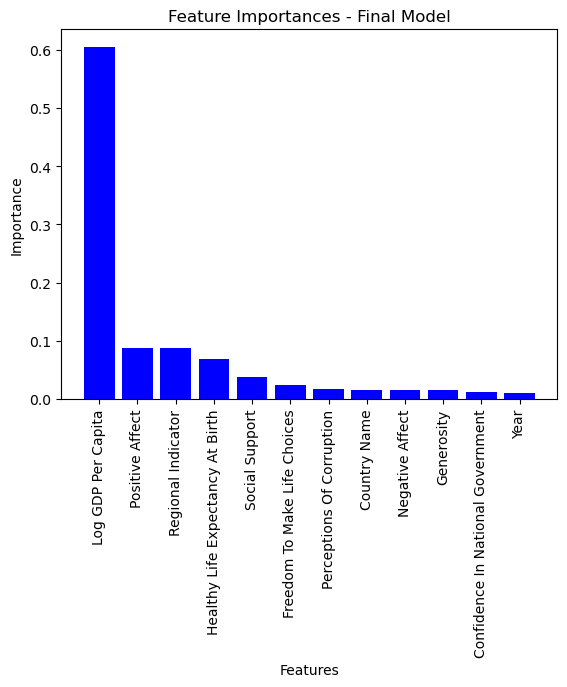

In [20]:
features, importances = zip(*feature_importance_tuples)

# Create a bar chart
plt.bar(features, importances, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances - Final Model')
plt.xticks(rotation=90)
plt.show()

We see here a familiar pattern in feature importances. Log GDP is by far the most important. 
This is no suprise given the previous data exploration in the Preprocessing and Training notebook. 

However, it is notable that the second and third most important features have changed somewhat. 
Based on previous analysis we would expect the second and third features to be Healthy Life Expectancy, Positive Affect and Regional Indicator.
We see here that Positive Affect is now second, replacing Healthy Life Expectancy and Regional Indicator has moved up one place as well. 
Regional indicator is especially interesting because it's not at all obvious why that would have any particular effect on Life Ladder scores. 
There is nothing in our data set to help us explore that question unfortunately. 

Even so, these factors are small in comparison to Log GDP. 

This doesn't mean that a higher GDP causes people living in a particular country to report being happier. We can't say that there is a causal relationship here. But we can say that there appears to be a significant positive coorelation between a strong econonmy in a general sense and self reported Life Ladder scores. 

# Save optimized Model<a id='Save optimized Model'></a>

In [21]:
rel_file_path = '../models'
abs_path = os.path.abspath(rel_file_path)
joblib.dump(rf_model_tuned,abs_path + '/rf_final.pkl')

['/Users/rossbrinkerhoff/Desktop/Springboard/Springboard_Brinkerhoff/Springboard_Capstone_2/Capstone_2/models/rf_final.pkl']